## Advanced Algorithmic Trading DT - V6

### Updates from Last Version
- Find Best Model using Grid Search. Fixed all gridsearch problems and do plotting
- Do for: 
    - Random Forest
    - Bagging
    - Boosting




#### Import Packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

import datetime
import gc

from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

from technical_indicators import * # import all function

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
#import parfit as pf
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression


#### Set Parameters

In [3]:
# Set the random seed, number of estimators and the "step factor" used to plot the graph of MSE for each method
random_state = 42  # Seed
n_jobs = -1 # -1 --> all Processors # Parallelisation factor for bagging, random forests (controls the number of processor cores used)
n_estimators = 200 # total number of estimators ot use in the MSE graph
step_factor = 10 # controls cranularity of calculation by stepping through the number of estimators
axis_step = int(n_estimators / step_factor) # 1000/10 = 100 separate calculations will be performed for each of the 3 ensebmle methods


#### Read in Data via GitHub URL

In [4]:
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)


***
## Clean Data & Create Technical Indicator Variables

- Create Deep copy of dataframe
- Use Adjusted Close Data
- Drop Close 
- Rename "Adj. Close" as "Close"
- Create Lagged Features
- Drop NaN
- Create Technical Indicator Variables
- Drop NaN
- Re-set index as Date

In [5]:
df_features = df_ORIGINAL.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
#df_features.head() # sanity check


"""
Creates Lagged Returns 
- given OHLCV dataframe
- numer of lagged days
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret


### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
#df_features.head(7)

# drop earlier data with missing lag features
df_features.dropna(inplace=True)
# reset index
df_features.reset_index(drop = True, inplace = True)


#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
#drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)



###########################################################################################
# Store Variables now for plots later
daily_index = df_features.index
daily_returns = df_features["Today"]
daily_price   = df_features["Close"]

# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)


,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999
2002-03-21,106.779999,104.699997,105.699997,5113100,74.516685,1.213226,-1.851283,1.071885,-0.411990,0.178246,...,0.571429,2.074850e+06,-1.411611e+07,1.220918e-07,-0.248791,95.547059,97.918488,93.175630,-0.008129,13.389999
2002-03-22,106.699997,105.070000,106.500000,5507900,73.693192,-1.105114,1.213226,-1.851283,1.071885,-0.411990,...,0.500000,9.123071e+05,1.101343e+06,3.426329e-08,-0.533297,95.592311,97.837311,93.347311,-0.021320,13.389999
2002-03-25,106.660004,103.500000,105.800003,6277900,72.269615,-1.931761,-1.105114,1.213226,-1.851283,1.071885,...,0.428571,1.004036e+06,1.890940e+06,-5.730833e-09,-1.582313,95.545348,97.848920,93.241776,-0.045311,13.389999
2002-03-26,105.699997,102.300003,103.570000,8144000,71.809052,-0.637285,-1.931761,-1.105114,1.213226,-1.851283,...,0.357143,-1.267786e+05,-1.083363e+06,-5.076478e-08,-1.978289,95.397427,97.776713,93.018141,-0.061006,11.739998


## Standardize Data & Create X & y

- Drop all data used to create technical indicators (this is done in the book)
- Then Standardize, necessary for PLS
- Run PLS
- Select Appropriate number of components
- Create X & y

NOTE: some technical indicators use Present  data, but for simplicity, just ignore this

In [6]:

### Standardize Data
##########################################################################################
# Drop Columns
list_of_columns_to_exclude = ["High", "Low", "Open", "Volume","Close", "Today"]
X_temp_standardized = df_features.copy(deep=True)
X_temp_standardized.drop(list_of_columns_to_exclude, axis = 1, inplace = True) # drop columns

# Standardize
X_temp_standardized
dates = X_temp_standardized.index # get dates to set as index after data is standardized
names = X_temp_standardized.columns # Get column names first
X_temp_standardized = StandardScaler().fit_transform(X_temp_standardized)

# Convert to DataFrame
X_temp_standardized = pd.DataFrame(X_temp_standardized, columns=names, index=dates)
X = X_temp_standardized


### Get y
##########################################################################################
y_temp = pd.DataFrame(df_features["Today"], index=X.index) # can only standardize a dataframe
sc = StandardScaler()
y = sc.fit_transform(y_temp) # Standardize, cause we did it for our original variables
y = pd.DataFrame(y, index=X.index, columns=["Today"]) # convert back to dataframe
y = y["Today"] # now re-get y as a Pandas Series

### Sanity Check
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check Types
print(type(X)) # Needs to be <class 'pandas.core.frame.DataFrame'>
print(type(y)) # Needs ro be <class 'pandas.core.series.Series'>



Shape of X:  (4190, 42)
Shape of y:  (4190,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


#### Split: Train & Validatte / Test

- Train & Validate: < '2018-01-01'
- Test: >= '2018-01-01'

In [7]:

X_train_all = X.loc[(X.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# # creates all test data which is all after January 2018
X_test = X.loc[(X.index >= '2018-01-01'),:]
y_test = y[X_test.index]

### Sanity Check
print("Shape of X_train_all: ", X_train_all.shape)
print("Shape of y_train_all: ", y_train_all.shape)
print("Shape of X_test:      ", X_test.shape)
print("Shape of y_test:      ", y_test.shape)




Shape of X_train_all:  (3979, 42)
Shape of y_train_all:  (3979,)
Shape of X_test:       (211, 42)
Shape of y_test:       (211,)


## Time Series Train Test Split ---- 


### Random Forest

In [8]:
"""
Execute Random Forest for differnt number of Time Series Splits
"""
def Call_Random_Forest(numSplits):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123, max_features="sqrt", min_samples_split=4, max_depth=30, min_samples_leaf=1)

    rf_mse = [] # MSE
    rf_r2 = [] # R2

    
    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_val.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_val.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        rf_mse.append(mse)
        rf_r2.append(r2)

    # print("rf_mse: ", rf_mse)
    # print("rf_r2: ", rf_r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Random Forest - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), rf_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), rf_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("rf_r2: ", rf_r2)
    #print(rf.feature_importances_)
    print("Mean r2: ", np.mean(rf_r2))



### Bagging

In [9]:
"""
Execute Bagging for differnt number of Time Series Splits
"""
def Call_Bagging(numSplits):
    ### Prepare Bagging
    ##############################################################################
    # Initialize Bagging Instance
    bagging = BaggingRegressor(n_estimators=150, n_jobs=-1, random_state=123)

    bagging_mse = [] # MSE
    bagging_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        bagging.fit(X_train, y_train)
        prediction = bagging.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        

        bagging_mse.append(mse)
        bagging_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Bagging - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), bagging_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), bagging_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("bagging_r2: ", bagging_r2)
    print(np.mean(bagging_r2))



### Boosting

In [10]:
"""
Execute Random Forest for differnt number of Time Series Splits
"""
def Call_Boosting(numSplits):
    ### Prepare Boosting
    ##############################################################################
    # Initialize Boosting Instance    
    boosting = AdaBoostRegressor(DecisionTreeRegressor(),
                                 n_estimators=150, random_state=123,learning_rate=0.01)

    boosting_mse = [] # MSE
    boosting_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        boosting.fit(X_train, y_train)
        prediction = boosting.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        boosting_mse.append(mse)
        boosting_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Boosting - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), boosting_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), boosting_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("boosting_r2: ", boosting_r2)



### Linear Regression


In [11]:
"""
Execute Linear Regression for different number of Time Series Splits
"""
def Call_Linear(numSplits):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    linear = LinearRegression(n_jobs=-1, normalize=True, fit_intercept=False) # if we don't fit the intercept we get a better prediction

    linear_mse = [] # MSE
    linear_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        linear.fit(X_train, y_train)
        prediction = linear.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        r2 = np.corrcoef(y_val, prediction)[0, 1] 
        r2 = r2*r2 # square of correlation coefficient --> R-squared

        linear_mse.append(mse)
        linear_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Linear Regression - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), linear_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), linear_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("linear_r2: ", linear_r2)



### Misc. Graphs ---- Price, Returns & Cumulative Returns

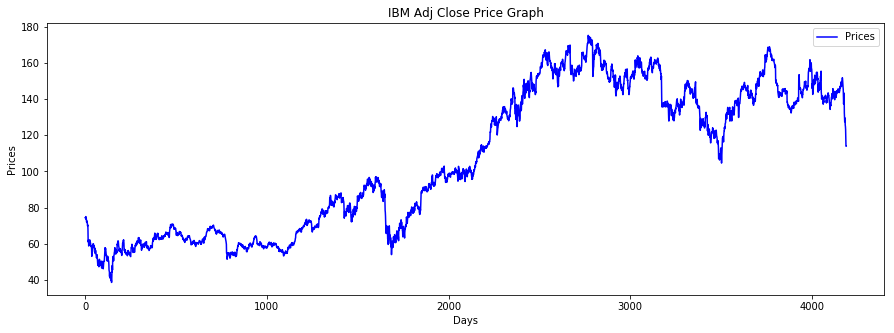

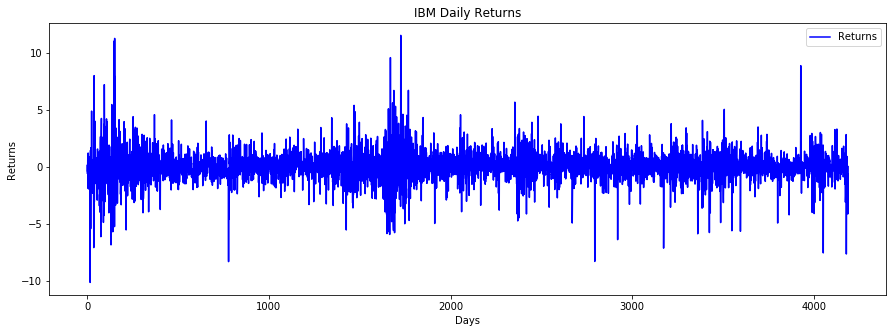

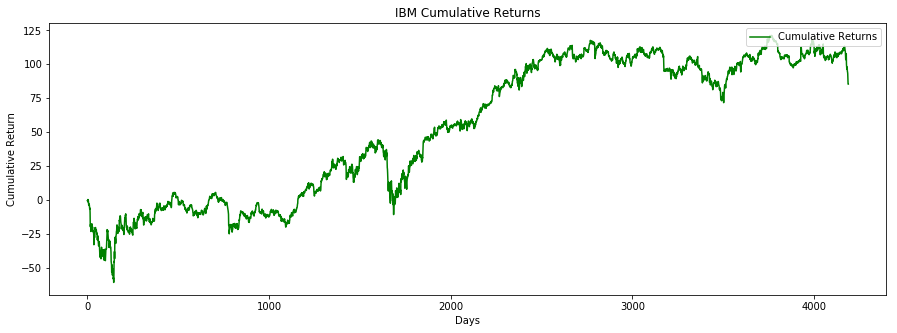

In [12]:
# figure dimenstions
length = 15
height = 5

### Prices
plt.figure(figsize=(length, height))
plt.title('IBM Adj Close Price Graph')
plt.plot(daily_index, daily_price, 'b-', color="blue", label='Prices')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.show()

### Returns
plt.figure(figsize=(length, height))
plt.title('IBM Daily Returns')
plt.plot(daily_index, daily_returns, 'b-', color="blue", label='Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.show()

### Cumulative Returns
plt.figure(figsize=(length, height))
plt.title('IBM Cumulative Returns')
cumulative_returns = daily_returns.cumsum()
plt.plot(daily_index, cumulative_returns, 'b-', color="green", label='Cumulative Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.show()


### First - A Note on R-Squared

##### What Does A Negative R Squared Value Mean?

- What does R-squared tell us?
    - It tells us whether a horizonal line through the vertical mean of the data is a better predictor
- For a Linear Regression
    - R-squared is just the coreelation coefficient squared
    - R-squared can't be negative, becasue at 0, it becomes the horizontal line
- For All other Model
    - For practical purposes, the lowest R2 you can get is zero, but only because the assumption is that if your regression line is not better than using the mean, then you will just use the mean value.  
    - However if your regression line is worse than using the mean value, the r squared value that you calculate will be negative.
    - Note that the reason R2 can't be negative in the linear regression case is just due to chance and how linear regression is contructed
    

***  
***  
***  

## Grid Search for Best Model

### Random Forest

In [13]:
"""
Execute Random Forest for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - minSamplesSplit: 
    - maxDepth: Max Depth of the DT
    - minSamplesLeaf: 
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits
"""
def Call_Random_Forest_Grid_Search(numSplits, minSamplesSplit, maxDepth, minSamplesLeaf):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    rf_mse = [] # MSE
    rf_r2 = [] # R2
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123, max_features="sqrt", 
                                   min_samples_split=minSamplesSplit, 
                                   max_depth=maxDepth, 
                                   min_samples_leaf=minSamplesLeaf)

    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_val.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_val.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        rf_mse.append(mse)
        rf_r2.append(r2)
    
    #print("rf_r2: ", rf_r2)
    #print(rf.feature_importances_)
    #print("Mean r2: ", np.mean(rf_r2))
    return np.mean(rf_r2)


In [14]:
# Call_Random_Forest_Grid_Search(numSplits, minSamplesSplit, maxDepth, minSamplesLeaf)

minSamplesSplit_list = [2,5,10,15,20]
maxDepth_list        = [15,20,25]
minSamplesLeaf_list  = [2,5,10]

best_model_parameters = [0,0,0]
max_r2 = -100
count = 0
# Loop over all possible parameters
for minSamplesSplit in minSamplesSplit_list:
    for maxDepth in maxDepth_list:
        for minSamplesLeaf in minSamplesLeaf_list:
            count += 1
            temp_mean_r2 = Call_Random_Forest_Grid_Search(20, minSamplesSplit, maxDepth, minSamplesLeaf) # Call Random Forest Train/Validation
            print("temp_mean ", count, ": ",  temp_mean_r2)
            if temp_mean_r2 > max_r2:
                max_r2 = temp_mean_r2 # store new max
                best_model_parameters[0] = minSamplesSplit
                best_model_parameters[1] = maxDepth
                best_model_parameters[2] = minSamplesLeaf
                
print("Best R2: ", max_r2)         


temp_mean  1 :  0.4152393483851412
temp_mean  2 :  0.40112393192660695
temp_mean  3 :  0.37500110605741793
temp_mean  4 :  0.42504504792303
temp_mean  5 :  0.4020915702097881
temp_mean  6 :  0.37789830291679244
temp_mean  7 :  0.4260665004618831
temp_mean  8 :  0.40321935330131914
temp_mean  9 :  0.3773010491459713
temp_mean  10 :  0.41229273946186196
temp_mean  11 :  0.40112393192660695
temp_mean  12 :  0.37500110605741793
temp_mean  13 :  0.4237741057518093
temp_mean  14 :  0.4020915702097881
temp_mean  15 :  0.37789830291679244
temp_mean  16 :  0.42505681396587996
temp_mean  17 :  0.40321935330131903
temp_mean  18 :  0.3773010491459713
temp_mean  19 :  0.40692511487122573
temp_mean  20 :  0.40112393192660695
temp_mean  21 :  0.37500110605741793
temp_mean  22 :  0.4158775170077121
temp_mean  23 :  0.4020915702097881
temp_mean  24 :  0.37789830291679244
temp_mean  25 :  0.41815307511520217
temp_mean  26 :  0.40321935330131914
temp_mean  27 :  0.3773010491459713
temp_mean  28 :  0.3994

In [15]:
best_model_parameters

[2, 25, 2]

In [16]:
minSamplesSplit_list = [4,5,6]
maxDepth_list        = [25,30,35]
minSamplesLeaf_list  = [1,2,3]

best_model_parameters = [0,0,0]
max_r2 = -100
count = 0
# Loop over all possible parameters
for minSamplesSplit in minSamplesSplit_list:
    for maxDepth in maxDepth_list:
        for minSamplesLeaf in minSamplesLeaf_list:
            count += 1
            temp_mean_r2 = Call_Random_Forest_Grid_Search(20, minSamplesSplit, maxDepth, minSamplesLeaf) # Call Random Forest Train/Validation
            print("temp_mean ", count, ": ",  temp_mean_r2)
            if temp_mean_r2 > max_r2:
                max_r2 = temp_mean_r2 # store new max
                best_model_parameters[0] = minSamplesSplit
                best_model_parameters[1] = maxDepth
                best_model_parameters[2] = minSamplesLeaf
                
print("Best R2: ", max_r2) 

temp_mean  1 :  0.4208541159206026
temp_mean  2 :  0.426066500461883
temp_mean  3 :  0.4204578372513034
temp_mean  4 :  0.42403400934881247
temp_mean  5 :  0.4279414869411088
temp_mean  6 :  0.4207766397857847
temp_mean  7 :  0.4253899798333702
temp_mean  8 :  0.4272168268215494
temp_mean  9 :  0.42082542711625665
temp_mean  10 :  0.4242753135236546
temp_mean  11 :  0.42505681396587996
temp_mean  12 :  0.42045783725130353
temp_mean  13 :  0.4245891036734147
temp_mean  14 :  0.4290240132859869
temp_mean  15 :  0.4207766397857847
temp_mean  16 :  0.42778644824354134
temp_mean  17 :  0.4280631196672432
temp_mean  18 :  0.42082542711625665
temp_mean  19 :  0.4214620550883582
temp_mean  20 :  0.42243004194373873
temp_mean  21 :  0.42045783725130353
temp_mean  22 :  0.4230708625088357
temp_mean  23 :  0.4225778723424828
temp_mean  24 :  0.4207766397857847
temp_mean  25 :  0.4258718787928292
temp_mean  26 :  0.4228890805186413
temp_mean  27 :  0.42082542711625665
Best R2:  0.4290240132859869


In [17]:
best_model_parameters

[5, 30, 2]

In [18]:
minSamplesSplit_list = [2,3,4]
maxDepth_list        = [29,30,31]
minSamplesLeaf_list  = [1,2]

best_model_parameters = [0,0,0]
max_r2 = -100
count = 0
# Loop over all possible parameters
for minSamplesSplit in minSamplesSplit_list:
    for maxDepth in maxDepth_list:
        for minSamplesLeaf in minSamplesLeaf_list:
            count += 1
            temp_mean_r2 = Call_Random_Forest_Grid_Search(20, minSamplesSplit, maxDepth, minSamplesLeaf) # Call Random Forest Train/Validation
            print("temp_mean ", count, ": ",  temp_mean_r2)
            if temp_mean_r2 > max_r2:
                max_r2 = temp_mean_r2 # store new max
                best_model_parameters[0] = minSamplesSplit
                best_model_parameters[1] = maxDepth
                best_model_parameters[2] = minSamplesLeaf
                
print("Best R2: ", max_r2) 
print(best_model_parameters)

temp_mean  1 :  0.4257956336131534
temp_mean  2 :  0.42695329286557915
temp_mean  3 :  0.4279772343340844
temp_mean  4 :  0.4279414869411089
temp_mean  5 :  0.4258599676304319
temp_mean  6 :  0.4270647986530882
temp_mean  7 :  0.4231816819829441
temp_mean  8 :  0.42695329286557904
temp_mean  9 :  0.42434080709121524
temp_mean  10 :  0.4279414869411089
temp_mean  11 :  0.42239834335285054
temp_mean  12 :  0.4270647986530882
temp_mean  13 :  0.42544494110946907
temp_mean  14 :  0.42695329286557904
temp_mean  15 :  0.42403400934881247
temp_mean  16 :  0.4279414869411089
temp_mean  17 :  0.4247090705732436
temp_mean  18 :  0.4270647986530882
Best R2:  0.4279772343340844
[2, 30, 1]


# Best Model: Random Forest

##### According to Grid Search, our best model is:
- [4, 30, 1]
- minSamplesSplit = 4
- maxDepth = 30
- minSamplesLeaf = 1

## Revised RandomForest

In [19]:
"""
Execute Random Forest for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - maxDepth: Max Depth of the DT
    - minSamplesLeaf: min samples to split (basically pruning)
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits
"""
def Call_Random_Forest_Grid_Search(numSplits, maxDepth, minSamplesLeaf):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    rf_mse = [] # MSE
    rf_r2 = [] # R2
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123, max_features="sqrt", 
                                   max_depth=maxDepth, 
                                   min_samples_leaf=minSamplesLeaf)

    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_val.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_val.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        rf_mse.append(mse)
        rf_r2.append(r2)
    
    #print("rf_r2: ", rf_r2)
    #print(rf.feature_importances_)
    #print("Mean r2: ", np.mean(rf_r2))
    return np.mean(rf_r2)


In [20]:
# Call_Random_Forest_Grid_Search(numSplits, minSamplesSplit, maxDepth, minSamplesLeaf)

minSamplesLeaf_list  = [2,5,10,15]
maxDepth_list        = [15,20,25,30]

best_model_parameters = [0,0]
max_r2 = -100
count = 0

rf_df = pd.DataFrame()
# Loop over all possible parameters
for minSamplesLeaf in minSamplesLeaf_list:
    for maxDepth in maxDepth_list:
        count += 1
        temp_mean_r2 = Call_Random_Forest_Grid_Search(20, maxDepth, minSamplesLeaf) # Call Random Forest Train/Validation
        print("temp_mean ", count, ": ",  temp_mean_r2)
        if temp_mean_r2 > max_r2:
            max_r2 = temp_mean_r2 # store new max
            best_model_parameters[0] = minSamplesLeaf
            best_model_parameters[1] = maxDepth
            
        rf_df.loc[count,'min_sample_leaf'] = minSamplesLeaf
        rf_df.loc[count,'max_depth'] = maxDepth
        rf_df.loc[count,'mean_r2'] = temp_mean_r2

print("Best R2: ", max_r2) 
print(best_model_parameters)

temp_mean  1 :  0.4152393483851412
temp_mean  2 :  0.42504504792303
temp_mean  3 :  0.426066500461883
temp_mean  4 :  0.4279414869411088
temp_mean  5 :  0.40112393192660695
temp_mean  6 :  0.4020915702097881
temp_mean  7 :  0.40321935330131914
temp_mean  8 :  0.4037947304072199
temp_mean  9 :  0.37500110605741793
temp_mean  10 :  0.37789830291679244
temp_mean  11 :  0.3773010491459713
temp_mean  12 :  0.37734457458938425
temp_mean  13 :  0.3434169583606079
temp_mean  14 :  0.3430689309352212
temp_mean  15 :  0.3429203665041908
temp_mean  16 :  0.34292036650419083
Best R2:  0.4279414869411088
[2, 30]


In [21]:
import seaborn as sns

# plot nicely
x_index = np.unique(rf_df.loc[:,'min_sample_leaf'])
y_index = np.unique((rf_df.loc[:,'max_depth']))
a = pd.DataFrame(index = x_index, columns = y_index)

for i in x_index:
    for j in y_index:
        a.loc[i,j] = list(rf_df.loc[(rf_df['min_sample_leaf'] == i) & (rf_df['max_depth'] == j),'mean_r2'])[0].astype(float)
a = a.apply(pd.to_numeric)    
sns.heatmap(a)
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('r2')
plt.show()

AttributeError: 'float' object has no attribute 'astype'

### Bagging

In [22]:

"""
Execute Bagging for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - min_samples_leaf: minimum samples to split
    - max_depth: depth of tree
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits"""
def Call_Bagging_Grid_Search(numSplits, min_samples_leaf, max_depth):
    ### Prepare Bagging
    ##############################################################################
    # Initialize Bagging Instance
    bagging_mse = [] # MSE
    bagging_r2 = [] # R2
    bagging = BaggingRegressor(DecisionTreeRegressor(min_samples_leaf = min_samples_leaf, max_depth = max_depth),
                               n_estimators=150, random_state=123,
                               #n_jobs = -1,
                                  max_samples=100,
                                  max_features=20)
#     bagging = BaggingRegressor(n_estimators=150, n_jobs=-1, random_state=123)

    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Bagging
        bagging.fit(X_train, y_train)
        prediction = bagging.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        

        bagging_mse.append(mse)
        bagging_r2.append(r2)

    return np.mean(bagging_r2)

In [23]:
min_sample_leaf = [5,10,15]
max_depth = [5,10,15]

best_model_parameters_bag = [0,0]
max_r2_bag = -100
count = 0

bag_df = pd.DataFrame()
# Loop over all possible parameters
for minSampleLeaf in min_sample_leaf:
    for maxDepth in max_depth:
        count += 1
        temp_mean_r2 = Call_Bagging_Grid_Search(20, minSampleLeaf, maxDepth) # Call Boosting Train/Validation
        print("temp_mean ", count, ": ",  temp_mean_r2)
        if temp_mean_r2 > max_r2_bag:
            max_r2_bag = temp_mean_r2 # store new max
            best_model_parameters_bag[0] = minSampleLeaf
            best_model_parameters_bag[1] = maxDepth
        bag_df.loc[count,'min_sample_leaf'] = minSampleLeaf
        bag_df.loc[count,'max_depth'] = maxDepth
        bag_df.loc[count,'mean_r2'] = temp_mean_r2
                
print("Best R2: ", max_r2_bag) 
print(best_model_parameters_bag)

temp_mean  1 :  0.237422264874805
temp_mean  2 :  0.252950216462564
temp_mean  3 :  0.25298542922174116
temp_mean  4 :  0.2183413311337663
temp_mean  5 :  0.22038306410677272
temp_mean  6 :  0.22038306410677272
temp_mean  7 :  0.19114925456024703
temp_mean  8 :  0.19114925456024703
temp_mean  9 :  0.19114925456024703
Best R2:  0.25298542922174116
[5, 15]


In [24]:
import seaborn as sns

# plot nicely
x_index = np.unique(bag_df.loc[:,'min_sample_leaf'])
y_index = np.unique((bag_df.loc[:,'max_depth']))
a = pd.DataFrame(index = x_index, columns = y_index)

for i in x_index:
    for j in y_index:
        a.loc[i,j] = list(bag_df.loc[(bag_df['min_sample_leaf'] == i) & (bag_df['max_depth'] == j),'mean_r2'])[0].astype(float)
a = a.apply(pd.to_numeric)    
sns.heatmap(a)
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('r2')
plt.show()

AttributeError: 'float' object has no attribute 'astype'

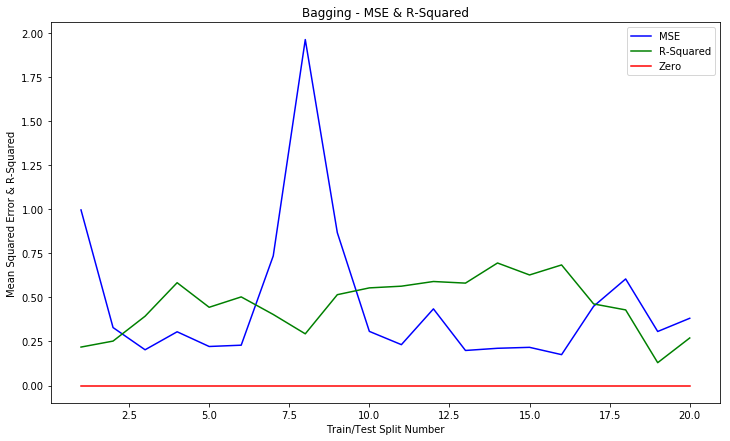

bagging_r2:  [0.21824737226138602, 0.25223705317335643, 0.39344805258982074, 0.5837255808076093, 0.44418226844096353, 0.503119310299019, 0.4033657352463198, 0.2934211773968288, 0.515725950607143, 0.5543141279413949, 0.5639820280192189, 0.5905512963025006, 0.5814117907214866, 0.6956958935932527, 0.6277419358537137, 0.684647904632731, 0.4631997503752032, 0.42923903874030656, 0.1296587908001735, 0.269944476113824]
0.45989297669581264


In [25]:
Call_Bagging(20)

# Best Model: Bagging

##### According to Grid Search, our best model is:
- minsampleleaf = 5
- maxdepth = 15
- I had to put max-samples as 100, because some of the split has max samples of only slightly over 100

# AdaBoost

In [26]:
"""
Execute Boosting for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - min_samples_leaf: Mininum number of samples to split. if a leaf node has greater than this parameter, we can still split
    - max_depth: depth of tree
    - learning_rate: gradient descent alpha
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits"""
def Call_Boosting_Grid_Search(numSplits, min_samples_leaf, max_depth, learning_rate):
    ### Prepare Bagging
    ##############################################################################
    # Initialize Bagging Instance
    boost_mse = [] # MSE
    boost_r2 = [] # R2
    boost = AdaBoostRegressor(DecisionTreeRegressor(max_features = 'sqrt', random_state = 123, min_samples_leaf = min_samples_leaf,
                                                   max_depth = max_depth),
                                 n_estimators=150, random_state=123,learning_rate=learning_rate)


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        boost.fit(X_train, y_train)
        prediction = boost.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        

        boost_mse.append(mse)
        boost_r2.append(r2)

    return np.mean(boost_r2)

In [27]:
### WARNING TAKES VERY LONG TO RUN
min_sample_leaf = [5,10,15]
max_depth = [5,10,15]
learning_rate = [0.01,0.1,1]

best_model_parameters_boost = [0,0,0]
max_r2_boosting = -100
count = 0

boosting_df = pd.DataFrame()
# Loop over all possible parameters
for minSampleLeaf in min_sample_leaf:
    for maxDepth in max_depth:
        for learn in learning_rate:
            count += 1
            temp_mean_r2 = Call_Boosting_Grid_Search(20, minSampleLeaf, maxDepth, learn) # Call Boosting Train/Validation
            print("temp_mean ", count, ": ",  temp_mean_r2)
            if temp_mean_r2 > max_r2_boosting:
                max_r2_boosting = temp_mean_r2 # store new max
                best_model_parameters_boost[0] = minSampleLeaf
                best_model_parameters_boost[1] = maxDepth
                best_model_parameters_boost[2] = learn
            boosting_df.loc[count,'min_sample_leaf'] = minSampleLeaf
            boosting_df.loc[count,'max_depth'] = maxDepth
            boosting_df.loc[count, 'Learning_rate'] = learn
            boosting_df.loc[count,'mean_r2'] = temp_mean_r2
                
print("Best R2: ", max_r2_boosting) 
print(best_model_parameters_boost)

temp_mean  1 :  0.22325918177772147
temp_mean  2 :  0.27072742196008365
temp_mean  3 :  0.31456774762275636
temp_mean  4 :  0.34308017742406866
temp_mean  5 :  0.38947650022402547
temp_mean  6 :  0.46084201732357544
temp_mean  7 :  0.41327094039883994
temp_mean  8 :  0.43222187048175026
temp_mean  9 :  0.4712166920877808
temp_mean  10 :  0.22957882840443283
temp_mean  11 :  0.2675544533482527
temp_mean  12 :  0.2928941552246179
temp_mean  13 :  0.3422734371853986
temp_mean  14 :  0.3736865106529043
temp_mean  15 :  0.4451994428957794
temp_mean  16 :  0.40641720474639875
temp_mean  17 :  0.4241205985599984
temp_mean  18 :  0.45812403971921756
temp_mean  19 :  0.23555515388465298
temp_mean  20 :  0.2644866903980452
temp_mean  21 :  0.2757487763492287
temp_mean  22 :  0.3421921604552499
temp_mean  23 :  0.36180837671730315
temp_mean  24 :  0.4207722547916986
temp_mean  25 :  0.39499833513796534
temp_mean  26 :  0.4162007303117082
temp_mean  27 :  0.4536800293140312
Best R2:  0.47121669208

In [28]:
display(boosting_df)

,min_sample_leaf,max_depth,Learning_rate,mean_r2
1,5.0,5.0,0.01,0.223259
2,5.0,5.0,0.10,0.270727
3,5.0,5.0,1.00,0.314568
4,5.0,10.0,0.01,0.343080
5,5.0,10.0,0.10,0.389477
6,5.0,10.0,1.00,0.460842
7,5.0,15.0,0.01,0.413271
8,5.0,15.0,0.10,0.432222
9,5.0,15.0,1.00,0.471217
10,10.0,5.0,0.01,0.229579


In [29]:
import seaborn as sns

# plot nicely
for learn in ([0.01,0.1,1]):
    x_index = np.unique(boosting_df.loc[:,'min_sample_leaf'])
    y_index = np.unique((boosting_df.loc[:,'max_depth']))
    a = pd.DataFrame(index = x_index, columns = y_index)
    
    for i in x_index:
        for j in y_index:
            a.loc[i,j] = list(boosting_df.loc[(boosting_df['min_sample_leaf'] == i) & (boosting_df['max_depth'] == j) & (boosting_df['Learning_rate'] == learn),'mean_r2'])[0].astype(float)
    a = a.apply(pd.to_numeric)    
    sns.heatmap(a)
    plt.title('learning_rate' + str(learn))
    plt.xlabel('min_samples_leaf')
    plt.ylabel('max_depth')
    plt.show()

AttributeError: 'float' object has no attribute 'astype'

## Best Model:

#### According to Grid Search, our best model is:
- min_samples_leaf = 5
- max_depth = 15
- learning_rate = 1

## FINAL PREDICTION

In [41]:
train_mse=[]
train_r2=[]
test_mse=[]
test_r2=[]

In [42]:
# RandomForestRegressor
rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123, max_features="sqrt", 
                                   max_depth=30, 
                                   min_samples_leaf=10)
rf.fit(X_train_all, y_train_all)
mse_train = mean_squared_error(y_train_all, rf.predict(X_train_all))
r2_train  = r2_score(y_train_all, rf.predict(X_train_all))

mse_test = mean_squared_error(y_test, rf.predict(X_test))
r2_test  = r2_score(y_test, rf.predict(X_test))

train_mse.append(mse_train)
train_r2.append(r2_train)
test_mse.append(mse_test)
test_r2.append(r2_test)

print('MSE on Train:', mse_train)
print('r2 on Train:', r2_train)

print('MSE on Test:', mse_test)
print('r2 on Test:', r2_test)

MSE on Train: 0.40316692248384484
r2 on Train: 0.5953291311057995
MSE on Test: 0.6775734039032278
r2 on Test: 0.36173634834302526


In [44]:
# bagging
bag = BaggingRegressor(DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 5),
                       n_estimators=150, n_jobs=1, random_state=123,
                                  max_samples=1500,
                                  max_features=20)
bag.fit(X_train_all, y_train_all)
mse_train = mean_squared_error(y_train_all, bag.predict(X_train_all))
r2_train  = r2_score(y_train_all, bag.predict(X_train_all))

mse_test = mean_squared_error(y_test, bag.predict(X_test))
r2_test  = r2_score(y_test, bag.predict(X_test))

train_mse.append(mse_train)
train_r2.append(r2_train)
test_mse.append(mse_test)
test_r2.append(r2_test)


print('MSE on Train:', mse_train)
print('r2 on Train:', r2_train)

print('MSE on Test:', mse_test)
print('r2 on Test:', r2_test)

MSE on Train: 0.41015188718277773
r2 on Train: 0.5883181101706043
MSE on Test: 0.6615864156118443
r2 on Test: 0.3767958436937505


In [45]:
# BOOSTING
boost = AdaBoostRegressor(DecisionTreeRegressor(max_features = 'sqrt', random_state = 123, min_samples_leaf = 5,
                                                   max_depth = 15),
                                 n_estimators=150, random_state=123,learning_rate=1)

boost.fit(X_train_all, y_train_all)
mse_train = mean_squared_error(y_train_all, boost.predict(X_train_all))
r2_train  = r2_score(y_train_all, boost.predict(X_train_all))

mse_test = mean_squared_error(y_test, boost.predict(X_test))
r2_test  = r2_score(y_test, boost.predict(X_test))

train_mse.append(mse_train)
train_r2.append(r2_train)
test_mse.append(mse_test)
test_r2.append(r2_test)


print('MSE on Train:', mse_train)
print('r2 on Train:', r2_train)

print('MSE on Test:', mse_test)
print('r2 on Test:', r2_test)

MSE on Train: 0.08044147956906791
r2 on Train: 0.9192584470179243
MSE on Test: 0.6093045642895996
r2 on Test: 0.42604453785455154


<function matplotlib.pyplot.show(*args, **kw)>

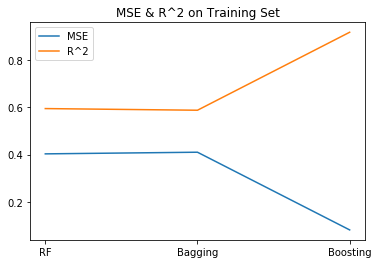

In [56]:
plt.plot(['RF','Bagging','Boosting'],train_mse,label='MSE')
plt.plot(train_r2,label='R^2')
plt.legend()
plt.title('MSE & R^2 on Training Set')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

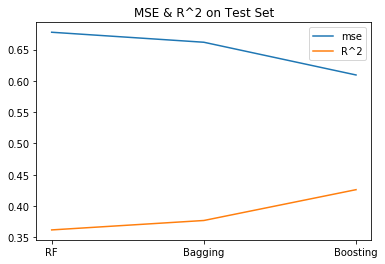

In [55]:
plt.plot(['RF','Bagging','Boosting'],test_mse,label='MSE')
plt.plot(test_r2,label='R^2')
plt.legend()
plt.title('MSE & R^2 on Test Set')
plt.show

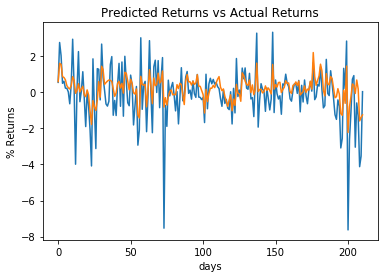

In [34]:
# plot best model which is boosting
plt.plot(sc.inverse_transform(np.array(y_test)))
plt.plot(sc.inverse_transform(boost.predict(X_test)))

plt.ylabel('% Returns')
plt.xlabel('days')
plt.title('Predicted Returns vs Actual Returns')
plt.show()